# Transfer Learning & Fine Tuning 

## What you'll learn in this class 🧐🧐

An interesting feature of deep learning models is that once it's been trained on some general task, it is possible to channel its predictive power for more specific tasks, this is called _Transfer Learning_.

The principle is simple, instead of building a neural network architecture from scratch, we will use pre-made and pre-trained architectures. This technique allows us to achieve _state of the art_ performance results. 

This course therefore aims to show how to perform _Transfer Learning_ with Tensorflow. We will use this for image recognition on flower types contained in a *flower_photos* folder.

## Loading dataset & preprocessing. 

### Downloading images from paths

In [31]:
import tensorflow as tf

We will use the *get_file* method of the *tf.keras.utils* module to download public data contained in Google Cloud Storage that we will then store in a *flower_photos* folder.

In [32]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='/content/flower_photos.tgz', 
                                         untar=True,
                                         cache_subdir="/content")
data_root = pathlib.Path("/content/flower_photos")
print(data_root)

/content/flower_photos


In the code above, we specify the following parameters: 

* `origin`: the url to which the data is contained 
* `fname`: is the name of the file you wish to download. You can also specify the path where the file should be stored.
* `untar`: This allows you to unpack files automatically. 
* `cache_subdir`: This specifies the subfolder where the decompressed data should be stored. 

Now let's take a look at the folder's content. 

In [33]:
for item in data_root.iterdir():
  print(item)

/content/flower_photos/dandelion
/content/flower_photos/daisy
/content/flower_photos/roses
/content/flower_photos/sunflowers
/content/flower_photos/tulips
/content/flower_photos/LICENSE.txt


We will now create an `ImageDataGenerator` object in order to use data augmentation on our flower images.

In [ ]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(#rotation_range=90,
                                                                brightness_range=(0.5,1), 
                                                                #shear_range=0.2, 
                                                                #zoom_range=0.2,
                                                                channel_shift_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rescale=1./255,
                                                                validation_split=0.3)

Now that we have set up the transformations we wish to apply to our images on the fly, we will create two objects that will be able to produce images on demand from the train set and valdiation set respectively.

We are able to set up the target image size and the batch size during this step too!

In [ ]:
img_generator_flow_train = img_generator.flow_from_directory(
    directory="/content/flower_photos",
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="training")

img_generator_flow_valid = img_generator.flow_from_directory(
    directory="/content/flower_photos",
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="validation")

Found 2572 images belonging to 5 classes.
Found 1098 images belonging to 5 classes.


Let's visualize a batch of images from the train set.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from pathlib import Path

imgs, labels = next(iter(img_generator_flow_train))
for img, label in zip(imgs, labels):
  true_file_path = np.argmax(img_generator_flow_train.labels == tf.argmax(label))
  true_label_name = Path(img_generator_flow_train.filepaths[true_file_path]).parent.name
  print("Label :", true_label_name)
  plt.imshow(img)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

We are now all set, and ready to embark on our transfer learning journey!

## Transfer Learning 

### Importing a pre-trained model 

Now that our images are pre-processed, we can move on to the modeling part. We will use an already existing architecture: MobileNet and use it to classify our flowers. Here is how we can proceed:

In [ ]:
base_model = tf.keras.applications.MobileNet(input_shape=(224,224,3), 
                                               include_top=False,
                                               weights = "imagenet"
                                               )

17227776/17225924 [==============================] - 0s 0us/step


Here we have imported the architecture to which we have specified not to take the last output layer. Indeed, this layer will be adapted to our need for flower classification. This model has been trained on a much larger number of different images from the <a href="http://www.image-net.org/">imagenet </a> dataset. 

Let's have a quick look at the architecture of our model:

In [34]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

Now we have to freeze our model so that only the custom layers will train.

In [35]:
base_model.trainable = False

This prevents us from training our entire model. Let us now add the last layer which interests us for our problem 

### Adapting the model to the dataset

When we imported our model, we removed the last layer to be able to adapt the model to our situation. So now let's use the next cell of code to add our last layer. 

We will use a `GlobalMaxPooling2D` layer which will output the most significant pixels of the image, and a last `Dense` layer which will take the number of classes of our dataset and a `softmax` activation function which will output probabilities for each of the predictions. 

In [36]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(set(img_generator_flow_train.labels)), activation="softmax")
])

Let's prepare our cost function, our optimization and a learning rate schedule to improve our prediction results and minimize our cost function. 

In [37]:
# Let's create a learning rate schedule to decrease the learning rate as we train the model. 
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)


In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 1024)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 3,233,989
Trainable params: 5,125
Non-trainable params: 3,228,864
_________________________________________________________________


Now let's practice our model.

In [40]:
model.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, epochs=5)

Epoch 1/5
81/81 [==============================] - 30s 350ms/step - loss: 3.2853 - categorical_accuracy: 0.4242 - val_loss: 0.9136 - val_categorical_accuracy: 0.7341
Epoch 2/5
81/81 [==============================] - 27s 335ms/step - loss: 0.4892 - categorical_accuracy: 0.8346 - val_loss: 0.6719 - val_categorical_accuracy: 0.8005
Epoch 3/5
81/81 [==============================] - 27s 340ms/step - loss: 0.3597 - categorical_accuracy: 0.8748 - val_loss: 0.5541 - val_categorical_accuracy: 0.8406
Epoch 4/5
81/81 [==============================] - 27s 339ms/step - loss: 0.2413 - categorical_accuracy: 0.9149 - val_loss: 0.7861 - val_categorical_accuracy: 0.7987
Epoch 5/5
81/81 [==============================] - 27s 340ms/step - loss: 0.2916 - categorical_accuracy: 0.9015 - val_loss: 0.5754 - val_categorical_accuracy: 0.8406


Our results are not bad already! We can however try to continue training our model but this time by releasing some layers. This is called _fine tuning_. So we're going to unlock the last 20 layers of the model. 

In [41]:
base_model = tf.keras.applications.MobileNet(input_shape=(224,224,3), 
                                               include_top=False,
                                               weights = "imagenet"
                                               )

In [42]:
len(base_model.layers)

86

In [43]:
base_model.trainable = True

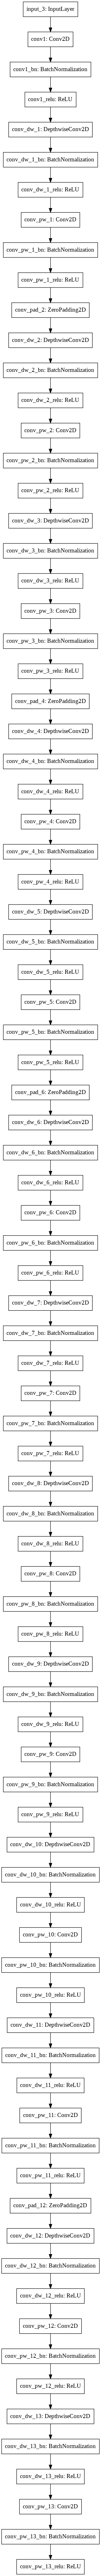

In [44]:
tf.keras.utils.plot_model(base_model)

In [45]:
fine_tune_at = len(base_model.layers) - 10
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [46]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(set(img_generator_flow_train.labels)), activation="softmax")
])

In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 1024)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5125      
Total params: 3,233,989
Trainable params: 1,593,349
Non-trainable params: 1,640,640
_________________________________________________________________


Let's try to train the model again. 

In [48]:
# You will need to run a new model.compile before re-training the model. 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])


model.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, epochs=5)

Epoch 1/5
81/81 [==============================] - 30s 352ms/step - loss: 2.1235 - categorical_accuracy: 0.6875 - val_loss: 3.8428 - val_categorical_accuracy: 0.5920
Epoch 2/5
81/81 [==============================] - 28s 342ms/step - loss: 0.4811 - categorical_accuracy: 0.8929 - val_loss: 1.9469 - val_categorical_accuracy: 0.6585
Epoch 3/5
81/81 [==============================] - 28s 342ms/step - loss: 0.2551 - categorical_accuracy: 0.9262 - val_loss: 1.0182 - val_categorical_accuracy: 0.7951
Epoch 4/5
81/81 [==============================] - 27s 336ms/step - loss: 0.2836 - categorical_accuracy: 0.9320 - val_loss: 1.9143 - val_categorical_accuracy: 0.6949
Epoch 5/5
81/81 [==============================] - 27s 332ms/step - loss: 0.3511 - categorical_accuracy: 0.9234 - val_loss: 1.8305 - val_categorical_accuracy: 0.7495


## Visualize the learning process

To visualize the learning process, you will use the `history` attribute from your model object.

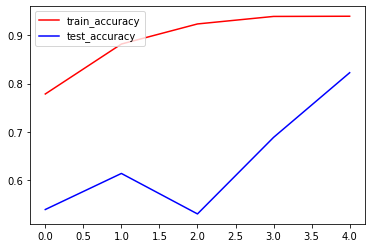

In [29]:
# Visualise train / Valid Accuracy
plt.plot(model.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

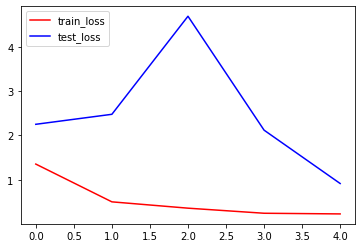

In [30]:
# Visualise train / Valid Loss
plt.plot(model.history.history["loss"], c="r", label="train_loss")
plt.plot(model.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

## Resources 📚📚

* [Transfer Learning using pre-trained ConvNets](https://www.tensorflow.org/beta/tutorials/images/transfer_learning)
* [History](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)